# library lobrary

In [75]:
import pandas as pd
import numpy as np 

# untuk visualisasi
import matplotlib.pyplot as plt 
import seaborn as sns

# library khusus untuk time series(prediksi)
# study kasus yang sifatnya trend ada analisis statsmodels : pengujian grafik untuk menentukan stasioner( data up to date) atau tidak
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# library untuk forcasting ( holtwinters (Simple exponensial smooting dan double exponensial) dan ARIMA)
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


### memanggil dataset

In [76]:
df = pd.read_excel('CO2 dataset.xlsx')

# Deskripsi Datset


In [77]:
df.head()

,Year,CO2
0,1800,0.00568
1,1801,0.00561
2,1802,0.00555
3,1803,0.00548
4,1804,0.00542


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    215 non-null    int64  
 1   CO2     215 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.5 KB


# Transform data (mengubah data)
##### karena ini data time series jadi harus ubah data tahun menjadi data time series (bulan-tanggal)

In [79]:
# coodingan ini untuk mengubah data dari tahun ke format tahun-bulan-tanggal
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

In [80]:
df.set_index(['Year'], inplace=True)
# set_index : digunakan untuk agar colomn year ada index paling awal
# inplace itu data langsung di ubah ke data utamanya kalau value nya True

In [81]:
df.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [82]:
# digunakan untuk melihat data minimum dan maksimum
df.index.min(), df.index.max()


(Timestamp('1800-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'))

In [83]:
# untuk cek data itu kontinu atau tidak
# data kontinu adalah  lalau data kontinu tuh bisa di katakan pada urutannya bisa menggunakan angka pecahan sedangkan kalok data diskrit tidak bisa pecahan
if(df.index.max() - df.index.min() == 214):
    print( " Daata is Continous")

In [84]:
# nge set df Dengan mengatur frekuensi waktu menjadi "YS" (year Start), Anda memberitahu pandas bahwa indeks DataFrame adalah serangkaian data dengan interval tahunan yang dimulai pada awal tahun. Ini akan menjadi informasi penting bagi pandas saat Anda melakukan manipulasi dan analisis data yang terkait dengan frekuensi waktu.
df.index.freq = "YS"

In [85]:
print(df)

                 CO2
Year                
1800-01-01   0.00568
1801-01-01   0.00561
1802-01-01   0.00555
1803-01-01   0.00548
1804-01-01   0.00542
...              ...
2010-01-01  15.60000
2011-01-01  15.60000
2012-01-01  14.80000
2013-01-01  14.70000
2014-01-01  15.10000

[215 rows x 1 columns]


## Analisa Time Series

<Axes: xlabel='Year'>

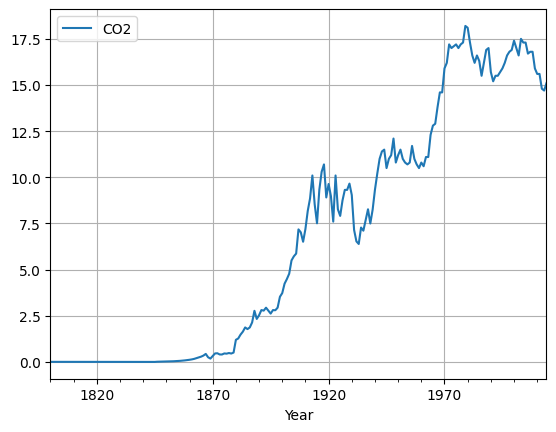

In [86]:
# untuk menambah  hubunga garis tegak lurus pada peta untuk memberikan orientasi spasial dengan muda pada pembaca peta.
df.plot(grid=True)

# menentukan data sasioner atau Tidak

In [87]:
train_df = df.loc[:'1991-01-01']
test_df = df.loc['1992-01-01':]

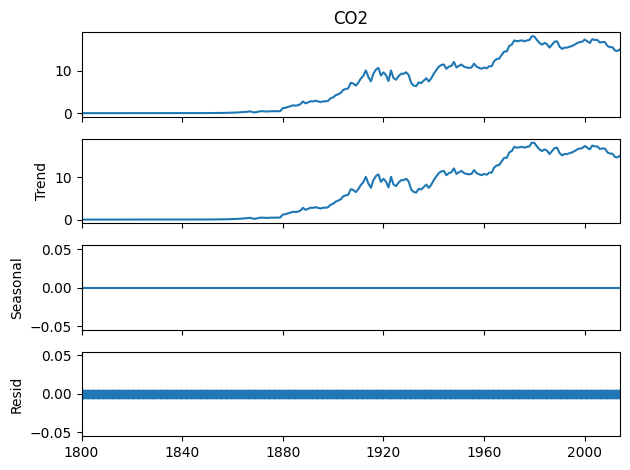

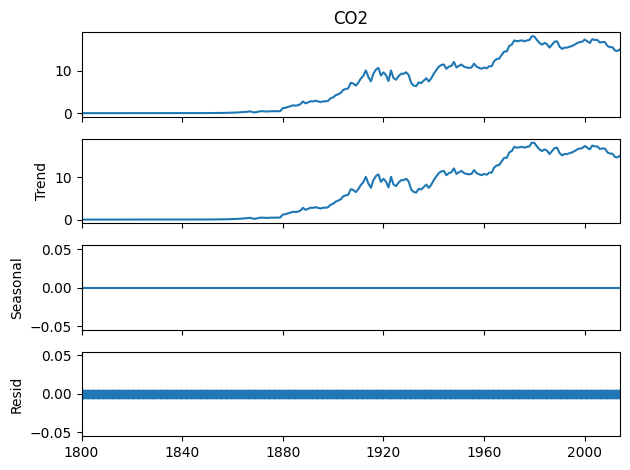

In [88]:
decompose_add = seasonal_decompose(df['CO2'])
decompose_add.plot()

In [89]:
def adf_test(timeseries):
    print('hasil testing cidekr')
    print('--------------------')
    adftest = adfuller(timeseries)
    adf_output = pd.Series(adftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'NUmberOf Obervatioj'])
    for key, Value in adftest[4].items() :
        adf_output['Critical Value (%s)' %key] = Value
    print(adf_output)

adf_test(df.values)

hasil testing cidekr
--------------------
Test Statistic           -0.378463
p-value                   0.913633
Lags Used                 0.000000
NUmberOf Obervatioj     214.000000
Critical Value (1%)      -3.461282
Critical Value (5%)      -2.875143
Critical Value (10%)     -2.574020
dtype: float64


In [90]:
# fungsinya untuk difpendencing untuk sasioneri(musiman/bulanan) nya
diff_df = df.diff()
diff_df.head()

,CO2
Year,
1800-01-01,NaN
1801-01-01,-0.00007
1802-01-01,-0.00006
1803-01-01,-0.00007
1804-01-01,-0.00006


In [91]:
# fungsinya untuk depending dari beberapa value yang berbeda
diff_df.dropna(inplace=True)

<Axes: xlabel='Year'>

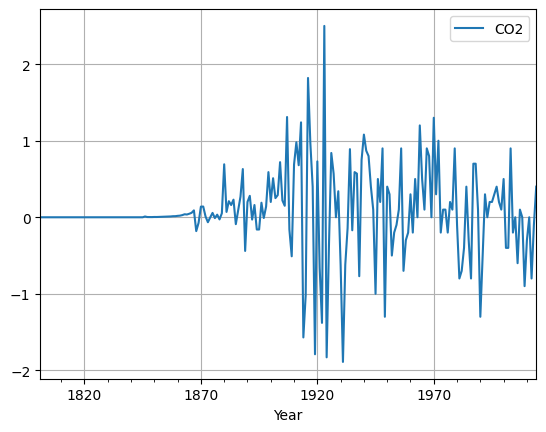

In [92]:
diff_df.plot(grid=True)

In [93]:
adf_test(diff_df)

hasil testing cidekr
--------------------
Test Statistic           -3.780005
p-value                   0.003119
Lags Used                15.000000
NUmberOf Obervatioj     198.000000
Critical Value (1%)      -3.463815
Critical Value (5%)      -2.876251
Critical Value (10%)     -2.574611
dtype: float64



##### Dari semuanya  bisa di tentukan bahwa ini termasuk datset sifat sasioner karena merupakan dataset berdasarkan perbulan atau musiman

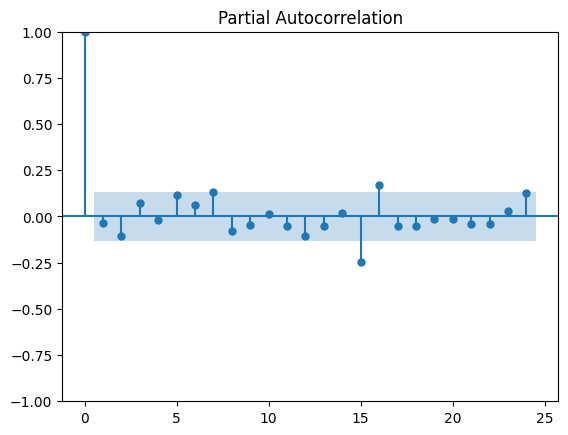

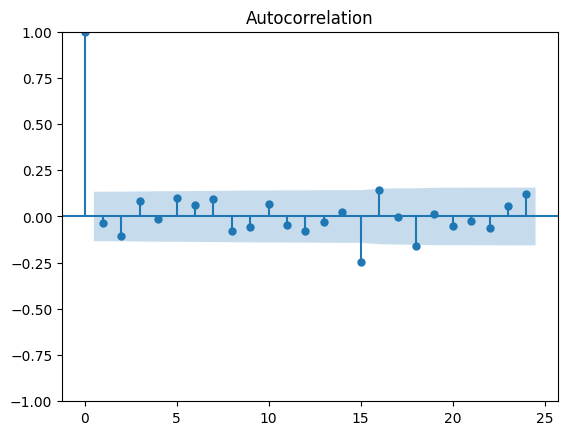

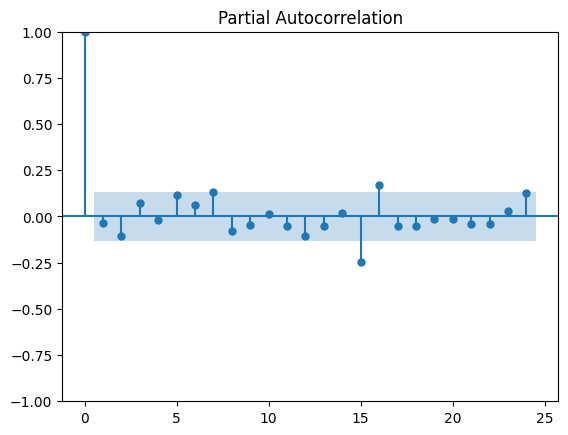

In [94]:
# ACF menunjukkan korelasi total antara suatu titik waktu dengan titik waktu lainnya, termasuk korelasi yang dijelaskan oleh lag-lag sebelumnya.
# PACF menunjukkan korelasi parsial antara suatu titik waktu dengan titik waktu lainnya, setelah menghilangkan korelasi yang dijelaskan oleh lag-lag sebelumnya.

# (lag-lag) disini berarti selisih waktu antara titik data pada saat tertentu(atau saat ini) dengan titik data pada waktu sebelumnya.
plot_acf(diff_df)
plot_pacf(diff_df)

### Implementasi Algoritma menggunakan 3 Algoritma untuk perbandingan

## 1. Single Exponensial Smothing

In [95]:
single_exp = SimpleExpSmoothing(train_df).fit()
single_exp_train_prad = single_exp.fittedvalues
single_exp_test_prad = single_exp.forecast(23)

# arti angka 23 untuk meramalkan nilai untuk 23 periode waktu ke depan (misalnya, 23 bulan atau 23 minggu ke depan) 


<Axes: xlabel='Year'>

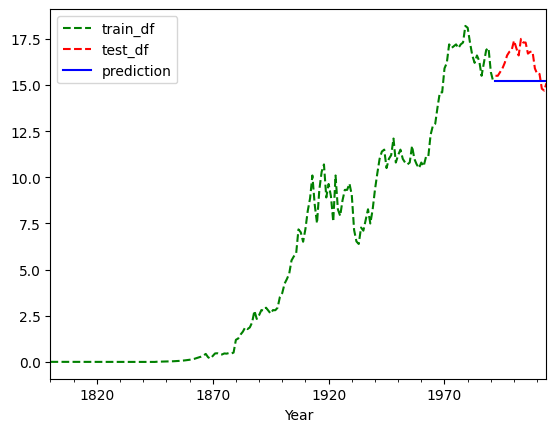

In [96]:
# label untuk data training
train_df['CO2'].plot(style='--', color='green', legend=True, label='train_df')

# label untuk data test
test_df['CO2'].plot(style='--', color='red', legend=True, label='test_df')

# coodingan legenda itu untuk menyajikan keterangan informasi warna ataupun garis2 tersebut

#hasil prediksi
single_exp_test_prad.plot(color='blue', legend=True, label='prediction')

In [97]:
# menampilkan RMSE dan MAPE nya
# Fungsi  Keduanya juga membantu kita membandingkan berbagai model peramalan dan memilih yang terbaik untuk tujuan analisis atau perencanaan

# Train RMSE
print('Train RMSE : ', mean_squared_error(train_df, single_exp_train_prad)**0.5)

# test RMSE
print('Test RMSE : ', mean_squared_error(test_df, single_exp_test_prad)**0.5)

# Train MAPE
print('Train MAPE : ', mean_absolute_percentage_error(train_df, single_exp_train_prad))

# test MAPE
print('Test MAPE : ', mean_absolute_percentage_error(test_df, single_exp_test_prad))

Train RMSE :  0.564692002680021
Test RMSE :  1.3429113022690744
Train MAPE :  0.08470457297144991
Test MAPE :  0.06861466412071275


## 2. Double Exponensial Smoothing

In [98]:
# untuk algortima nya
double_exp = ExponentialSmoothing(train_df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()

# train
double_exp_train_pred = double_exp.fittedvalues

# test
double_exp_test_pred = double_exp.forecast(23)

<Axes: xlabel='Year'>

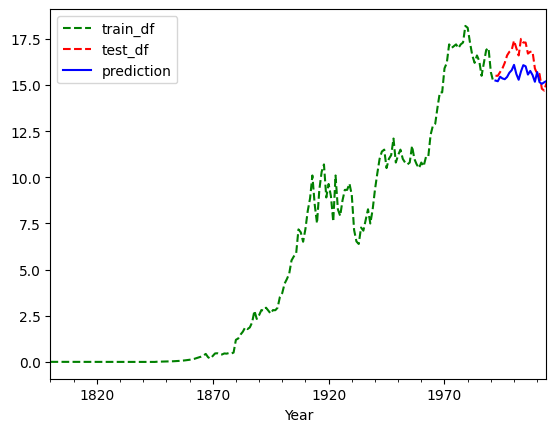

In [99]:
# label untuk data training
train_df['CO2'].plot(style='--', color='green', legend=True, label='train_df')

# label untuk data test
test_df['CO2'].plot(style='--', color='red', legend=True, label='test_df')

# coodingan legenda itu untuk menyajikan keterangan informasi warna ataupun garis2 tersebut

#hasil prediksi
double_exp_test_pred.plot(color='blue', legend=True, label='prediction')

In [100]:
# menampilkan RMSE dan MAPE nya
# Fungsi  Keduanya juga membantu kita membandingkan berbagai model peramalan dan memilih yang terbaik untuk tujuan analisis atau perencanaan

# Train RMSE
print('Train RMSE : ', mean_squared_error(train_df, double_exp_train_pred)**0.5)

# test RMSE
print('Test RMSE : ', mean_squared_error(test_df, double_exp_test_pred)**0.5)

# Train MAPE
print('Train MAPE : ', mean_absolute_percentage_error(train_df, double_exp_train_pred))

# test MAPE
print('Test MAPE : ', mean_absolute_percentage_error(test_df, double_exp_test_pred))

Train RMSE :  0.5576263311586229
Test RMSE :  0.9739218268464459
Train MAPE :  14.72268617058503
Test MAPE :  0.050781568455286974


# 3. ARIMA

In [101]:
ar = ARIMA(train_df, order=(15, 1, 15)).fit()
ar_train_pred = ar.fittedvalues
ar_test_pred = ar.forecast(23)

# method fit() atau proses "fitting" (melatih) model adalah salah satu tahap terpenting dalam pembelajaran mesin karena model yang benar-benar melatih diri pada data latih dapat memberikan hasil prediksi yang lebih akurat pada data baru. ia identik dengan data train karena berguna untuk melatih train data dengan test data

c:\Users\davar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Year'>

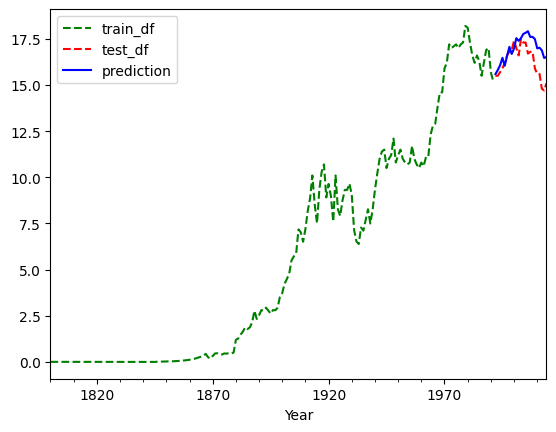

In [102]:
# label untuk data training
train_df['CO2'].plot(style='--', color='green', legend=True, label='train_df')

# label untuk data test
test_df['CO2'].plot(style='--', color='red', legend=True, label='test_df')

# coodingan legenda itu untuk menyajikan keterangan informasi warna ataupun garis2 tersebut

#hasil prediksi
ar_test_pred.plot(color='blue', legend=True, label='prediction')

In [103]:
# menampilkan RMSE dan MAPE nya
# Fungsi  Keduanya juga membantu kita membandingkan berbagai model peramalan dan memilih yang terbaik untuk tujuan analisis atau perencanaan

# Train RMSE
print('Train RMSE : ', mean_squared_error(train_df, ar_train_pred)**0.5)

# test RMSE
print('Test RMSE : ', mean_squared_error(test_df, ar_test_pred)**0.5)

# Train MAPE
print('Train MAPE : ', mean_absolute_percentage_error(train_df, ar_train_pred))

# test MAPE
print('Test MAPE : ', mean_absolute_percentage_error(test_df, ar_test_pred))

Train RMSE :  0.4679443015513223
Test RMSE :  0.9551165954671146
Train MAPE :  0.08155984742043461
Test MAPE :  0.047459224105826626


# Perbandingan ke-3 algoritma yang digunakan 



In [104]:
comparision_df = pd.DataFrame(data=[
    ['single_exp_smoothing', 1.3429, 0.0686],
    ['double_exp_smoothing', 0.53, 0.0260],
    ['ARIMA', 0.9549, 0.0472]
    ],
    columns=['model', 'RMSE', 'MAPE'])

comparision_df.set_index('model', inplace=True)

In [105]:
comparision_df.sort_values(by='RMSE')

,RMSE,MAPE
model,,
double_exp_smoothing,0.5300,0.0260
ARIMA,0.9549,0.0472
single_exp_smoothing,1.3429,0.0686


### setting untung penggunaan algoritma double exponensial smooting

In [106]:
# membuat model prediksi
# dia manggil datset yang secara keseluruhan yaitu dari thn 1990 sampai 2014
# karena yang sebelumnya hanya menggunakan data train ataupun data testing

# untuk algortima nya
double_exp = ExponentialSmoothing(df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()

double_exp_pred = double_exp.forecast(20) # memprediksi 20thn kedepan

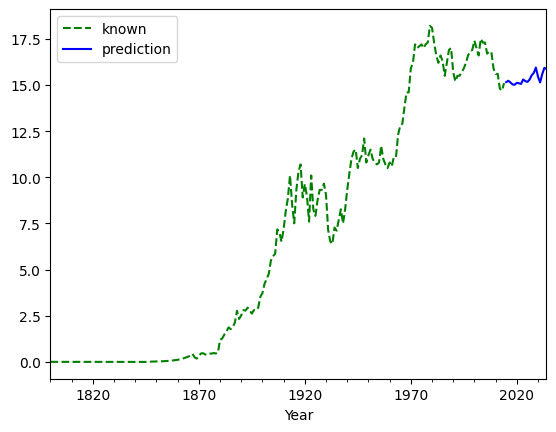

In [107]:
# plot untuk model algoritma SES 
# sebelum di pred
df['CO2'].plot(style='--', color='green', legend=True, label='known')

#hasil prediksi
double_exp_pred.plot(color='blue', legend=True, label='prediction')

plt.show()

In [108]:
import pickle

# fungsi Python pickle adalah modul bawaan dalam bahasa pemrograman Python yang digunakan untuk serialisasi dan deserialisasi objek Python. Serialisasi adalah proses mengubah objek Python menjadi bentuk yang dapat disimpan atau ditransmisikan, sedangkan deserialisasi adalah proses mengubah kembali objek dari bentuk yang disimpan atau ditransmisikan menjadi objek Python yang sesungguhnya.

In [109]:
# dump model
# Dumping model dalam konteks machine learning mengacu pada proses menyimpan model yang telah difittingkan ke dalam file atau penyimpanan permanen sehingga model dapat digunakan kembali di lain waktu tanpa harus melatihnya ulang.
# biar saat pengelolaan untuk interface dia tidak perlu melatih ulang atau fitting ulang
# karena sudah fiks makanya di dumping / disimpan permanen

pickle.dump(double_exp, open('prediksi_co2.sav', 'wb'))